 ### HW3Q5 Bernoulli mixtures for mnist

In [205]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.linalg import norm as norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels
with open('train-images-idx3-ubyte', 'rb') as f:
  train_images = extract_images(f)
with open('train-labels-idx1-ubyte', 'rb') as f:
  train_labels = extract_labels(f)

Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-images-idx3-ubyte
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-labels-idx1-ubyte


In [3]:
# reshape data 
data_x = train_images.reshape(60000, 28*28)/255
data_y = train_labels.reshape(60000, 1)
# setting the value to 1 if there is some ‘ink’ over that pixel
data_x[np.nonzero(data_x)] = 1

In [112]:
def compute_l(xi, p):
    # p is a column vector, xi is a row vector
    return xi@np.log(p) + (1 - xi)@np.log(1 - p)

In [189]:
# set random seed
np.random.seed(seed=0)
# estimate the responsibility
# M : number of components, N = training sample size
# D : number of dimensions
def compute_w(x, prob, pi, M):
    N = x.shape[0]
    l_init = np.zeros((N, M))
    w = np.zeros((N, M))
    for j in range(M):
        for i in range(N):
            l_init[i, j] = compute_l(x[i, :], prob[:, j])
        # calculate log(f_m) + log(pi_m)
        l_init[:, j] = l_init[:, j] + np.log(pi[j])
        
    for i in range(N):
        L = l_init[i, :][np.argmax(l_init[i, :])]
        for j in range(M):
            w[i, j] = np.exp(l_init[i, j] - L)
        row_sum = np.sum(w[i, :])
        w[i, :] = w[i, :]/row_sum
    return l_init, w

In [196]:
# iterations 
def EM_Bernoulli(x, max_iter, M):
    N, D = x.shape[0], x.shape[1]
    # initialize 
    init = np.random.randint(M, size = N)   
    pi_init = np.array([(np.nonzero(init == i)[0].shape[0] 
                         + 1)/(N + 2) for i in range(M)])
    # estimate responsibility 
    prob = (np.sum(x, axis = 0) + 1)/ (N + 2)
    prob = prob.reshape(D, 1)
    prob_init = np.concatenate([prob]*M, axis=1)
    l, w_init = compute_w(x, prob_init, pi_init, M)
    w_old, prob = w_init, np.zeros((D, M))
    iterate = True
    it, loss = 0, np.inf
    while it <= max_iter and iterate:
        it += 1
        # update pi
        pi = (np.sum(w_old, axis = 0) + 1)/(N + 2)
        # update probailities
        for j in range(D):
            for m in range(M):
                prob[j, m] = (np.dot(w_old[:, m].T, x[:, j]) + 1
                                 )/(np.sum(w_old[:, m]) + 2)
        # update w
        l, w_old = compute_w(x, prob, pi, M)
        loss_old = loss
        loss = np.sum(np.log(np.sum(np.exp(l), axis = 1)))
        if norm(loss - loss_old) <= 10**(-4):
            iterate = False
    return pi, prob, w_old 

In [186]:
# train by each figure class
# select figure class  e.g. y = 1
def train_figure(f, data_x, data_y, N, M):
    x = data_x[np.nonzero(data_y == f)[0]][:N, :]
    pi, prob, w_mat = EM_Bernoulli(x, 1000, M)   
    return pi, prob, w_mat

In [187]:
%matplotlib inline
def train_model(data_x, data_y, N, M):
    ncols, nrows = 10, M
    ps = np.zeros((10, M))
    probs = np.zeros((data_x.shape[1], 10*M))
    for f in range(10):
        ps[f, :], probs[:, M*f: M*(f+1)], w = train_figure(
            f, data_x, data_y, N, M)
                
    plt.figure(figsize=(ncols*1, nrows*1))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(probs.T[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()
    return ps, probs

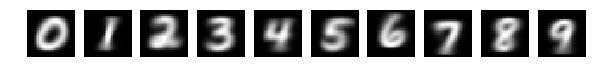

In [200]:
# image for probability M = 1
ps, probs = train_model(data_x, data_y, data_x.shape[0], 1)

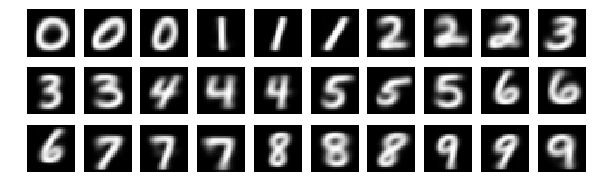

In [207]:
# image for probability M = 3
ps3, probs3 = train_model(data_x, data_y, data_x.shape[0], 3)

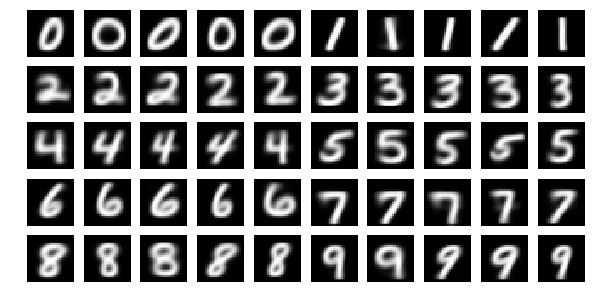

In [197]:
# image for probability M = 5
ps5, probs5 = train_model(data_x, data_y, data_x.shape[0], 5)

In [212]:
## model on test data set 
def test_model(test_x, probs, ps, M):
    p = np.zeros((N, 10))
    for i in range(10):
        f = np.zeros((N, M))
        for m in range(M):
            f[:, m] = (np.exp(test_x.dot(np.log(probs[:, i*M+m]))) + 
                       np.exp((1- test_x).dot(np.log(1 - probs[:, i*M+m]))))
        p[:, i] = f.dot(ps[i, :].T)
    max_cls = np.argmax(p, axis =1)        
    return max_cls 

In [208]:
test_x = data_x[N:2*N, :]
test_y = data_y[N:2*N, :]

In [213]:
# prediction error rate for M= 1
m1 = test_model(test_x, probs, ps, 1)
np.mean(m1 != test_y.reshape(len(test_y)))

0.635

In [214]:
# prediction error rate for M= 3
m3 = test_model(test_x, probs3, ps3, 3)
np.mean(m3 != test_y.reshape(len(test_y)))

0.376

In [215]:
# prediction error rate for M= 5
m5 = test_model(test_x, probs5, ps5, 5)
np.mean(m5 != test_y.reshape(len(test_y)))

0.31